In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sb
import math
from IPython.display import display, clear_output
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# set random seed to achieve same results each time
np.random.seed(23)

### Object to Hold Our Training, Dev and Test Data as Well as Simple Methods to Preprocess Data

In [61]:
class FacialKeypoints(object):
    
    def __init__(self):
        self.train_csv = pd.read_csv("training.csv")
        self.test_csv = pd.read_csv("test.csv")
        self.sample_csv = pd.read_csv("SampleSubmission.csv")
        self.ID_csv = pd.read_csv("IdLookupTable.csv")
        self.label_names = self.train_csv.columns.tolist()[:-1]
        self.dev_data_n, self.dev_labels_n, self.train_data_n, self.train_labels_n = self.create_training(self.train_csv)
        self.dev_data, self.dev_labels, self.train_data, self.train_labels = self.create_training(self.train_csv, nans=False)
        self.train_data_f, self.train_labels_f = self.flip_data(self.train_data), self.flip_labels(self.train_labels)
        self.test_data, _ = self._parse_data(self.test_csv)
    
    def create_training(self, train_csv, dev_size=1000, nans=True):
        if nans == False:
            train_csv = train_csv.dropna()
        data, labels = self._parse_data(train_csv)
        shuffle = np.random.permutation(np.arange(data.shape[0]))        
        data, labels              = data[shuffle], labels[shuffle]       # Shuffle the data
        dev_data, dev_labels      = data[:dev_size], labels[:dev_size]   # Splitting into dev and training
        train_data, train_labels  = data[dev_size:], labels[dev_size:]
        return dev_data, dev_labels, train_data, train_labels
    
    def plot_example(self, data, label, predicted_label=np.nan, legend=True):
        plt.imshow(data.reshape(96, 96), cmap='gray')
        plt.scatter(label[0::2], label[1::2], c='red', marker='x', label='actual')
        if np.all(np.isfinite(predicted_label)):
            plt.scatter(predicted_label[0::2], predicted_label[1::2], c='blue', marker='x', label='predicted')
        plt.axis('off')
        if legend:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
        return
    
    def score(self, y_pred, y_actual):
        return np.sqrt(mean_squared_error(y_actual, y_pred))
    
    def blur_data(self, data):
        data = data.reshape(data.shape[0], int(data.shape[1]**0.5), -1) 
        data = np.array([np.roll(np.roll(data, horizontal, axis=1), 
                                               vertical  , axis=2) 
                         for vertical in range(-1,2) for horizontal in range(-1,2)]
                       ).mean(axis=0)     
        return data.reshape(data.shape[0], -1)
    
    def submission_gen(self, predictions, file_name):
        df = pd.DataFrame(predictions, columns=self.train_csv.columns[:-1])
        pos = []
        for index, row in self.ID_csv.iterrows():
            pos.append((row['RowId'], df.iloc[row.ImageId - 1][row.FeatureName]))
        sub = pd.DataFrame(pos, columns=('RowId', 'Location'))
        sub.to_csv("./" + file_name + ".csv", index=False)
        return
    
    ## Various Methods to Create More Training Examples
    def average_nans(self, train_labels):
        df = pd.DataFrame(train_labels)
        return df.fillna(df.mean()).values
    
    def flip_data(self, train_data):
        num_images = train_data.shape[0]
        train_data = train_data.reshape(num_images, 96, 96)[..., ::-1].flatten()
        return train_data.reshape(num_images, 9216)
    
    def flip_labels(self, train_labels):
        df = pd.DataFrame(train_labels.copy(), columns=self.label_names)
        df.loc[:, df.columns.str.contains('_x')] = df.loc[:, df.columns.str.contains('_x')].applymap(self._flip_axis)
        return df.values
        
    ## Helper Functions
    def _flip_axis(self, value, axis=47):
        if value >= axis:
            return axis - np.abs(value - axis)
        else:
            return axis + np.abs(value - axis)
    
    def _parse_data(self, data):
        labels = data.loc[:, data.columns != 'Image'].values   # column Image is the image data
        data = data['Image'].str.split()                       # image data comes as one long string
        data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
        data = data/255.0                                      # Rescale grayscale values to [0,1].
        return data, labels
    
    pass

## Initialize the Object

In [62]:
self = FacialKeypoints()

## Missing Labels

We noticed that there are many examples that are missing a full label set. Out of the total 6049 examples, only 1140 have the full set of labels. Here is the percentage break out of each label

In [4]:
(self.train_csv.loc[:, self.train_csv.columns != 'Image'].count()/len(self.train_csv.index)).round(3)

left_eye_center_x            0.999
left_eye_center_y            0.999
right_eye_center_x           0.998
right_eye_center_y           0.998
left_eye_inner_corner_x      0.322
left_eye_inner_corner_y      0.322
left_eye_outer_corner_x      0.322
left_eye_outer_corner_y      0.322
right_eye_inner_corner_x     0.322
right_eye_inner_corner_y     0.322
right_eye_outer_corner_x     0.322
right_eye_outer_corner_y     0.322
left_eyebrow_inner_end_x     0.322
left_eyebrow_inner_end_y     0.322
left_eyebrow_outer_end_x     0.316
left_eyebrow_outer_end_y     0.316
right_eyebrow_inner_end_x    0.322
right_eyebrow_inner_end_y    0.322
right_eyebrow_outer_end_x    0.317
right_eyebrow_outer_end_y    0.317
nose_tip_x                   1.000
nose_tip_y                   1.000
mouth_left_corner_x          0.322
mouth_left_corner_y          0.322
mouth_right_corner_x         0.322
mouth_right_corner_y         0.322
mouth_center_top_lip_x       0.323
mouth_center_top_lip_y       0.323
mouth_center_bottom_

#### Plot Examples From Incomplete Labels

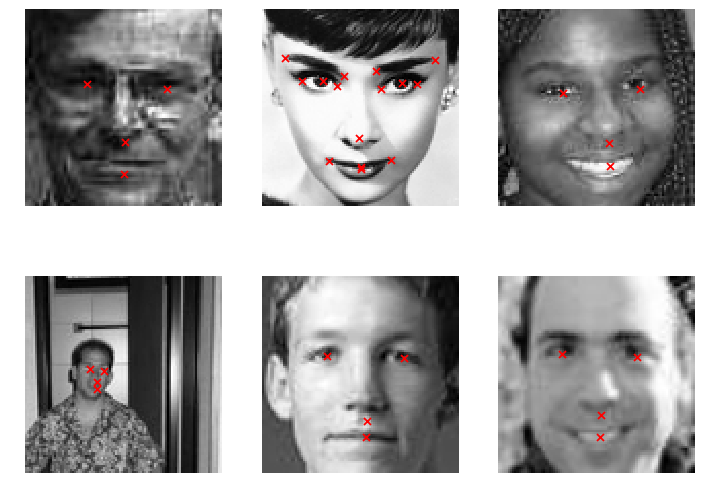

In [63]:
for n in range(1, 7):
    plt.subplot(2, 3, n)
    self.plot_example(self.train_data_n[n], self.train_labels_n[n], legend=False) 

#### Plot Examples From Complete Labels

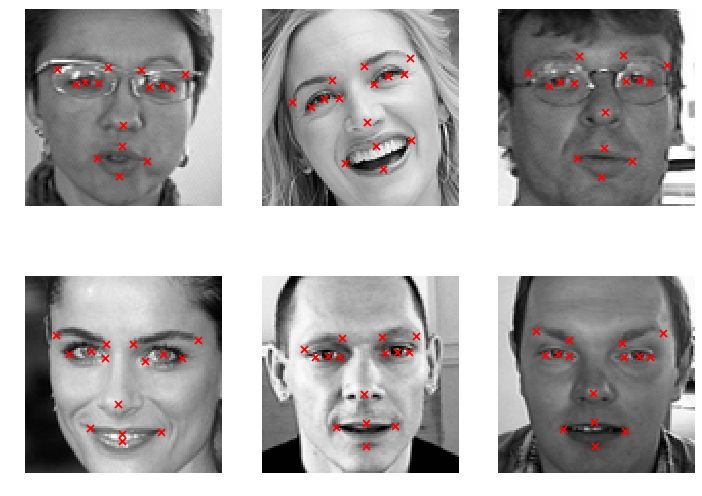

In [64]:
for n in range(1, 7):
    plt.subplot(2, 3, n)
    self.plot_example(self.train_data[n], self.train_labels[n], legend=False) 

## K-NN

#### Using only the training data with complete set of labels

In [7]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=self.train_data, y=self.train_labels)

y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

2.5699609194515616

#### Using blurring and _average_ _nans_

blur_data shifts the image 1 pixel in each direction and takes the mean, effectively returning a blurred image

In [9]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=self.blur_data(self.train_data_n), y=self.average_nans(self.train_labels_n))

y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

1.8225472133057437

In [22]:
pd.DataFrame(np.sqrt(mean_squared_error(self.dev_labels, y_pred, multioutput='raw_values')), 
             columns=['RMSE'], index=self.label_names).sort_values('RMSE', ascending=False)

,RMSE
nose_tip_y,3.024229
mouth_center_bottom_lip_y,2.605217
mouth_center_top_lip_y,2.578482
mouth_left_corner_y,2.394495
mouth_right_corner_y,2.289124
mouth_left_corner_x,2.178618
mouth_right_corner_x,2.149628
right_eyebrow_outer_end_y,2.147477
left_eyebrow_outer_end_y,2.087928
left_eyebrow_outer_end_x,1.898402


#### Plot a Prediction

RMSE of 1.06332539756


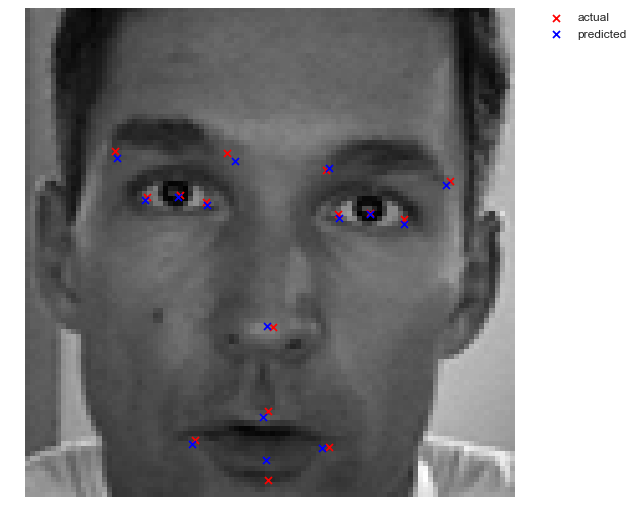

In [10]:
example_num = 25
print ('RMSE of '+ str((self.score(self.dev_labels[example_num], y_pred[example_num]))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], y_pred[example_num])

### Using Flipped Images to Extend Our Training Data

In [67]:
data = np.concatenate((self.train_data, self.train_data_f))
labels = np.concatenate((self.train_labels, self.train_labels_f))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

y_pred = knn.predict(self.dev_data) 
self.score(self.dev_labels, y_pred)

9.6123144945272987

## Neural Net

#### Standard Scale Training and Labels

In [23]:
data = self.train_data
labels = self.train_labels

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(500, 300, 100), early_stopping=True, verbose=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

Iteration 1, loss = 2.63948595
Validation score: -2.093595
Iteration 2, loss = 1.09531577
Validation score: -0.308900
Iteration 3, loss = 0.55650974
Validation score: -0.050124
Iteration 4, loss = 0.49288164
Validation score: -0.030043
Iteration 5, loss = 0.48683994
Validation score: -0.019131
Iteration 6, loss = 0.48203437
Validation score: -0.015977
Iteration 7, loss = 0.47417023
Validation score: -0.005643
Iteration 8, loss = 0.46990272
Validation score: -0.001915
Iteration 9, loss = 0.46361752
Validation score: 0.013114
Iteration 10, loss = 0.45588081
Validation score: 0.016475
Iteration 11, loss = 0.45210579
Validation score: 0.004225
Iteration 12, loss = 0.44273899
Validation score: 0.006110
Iteration 13, loss = 0.43498083
Validation score: 0.030658
Iteration 14, loss = 0.42744680
Validation score: 0.041654
Iteration 15, loss = 0.42572078
Validation score: 0.050809
Iteration 16, loss = 0.43554272
Validation score: 0.016810
Iteration 17, loss = 0.43614164
Validation score: 0.02994

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(500, 300, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [25]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

3.0430436481851051

#### Using _average_nans to preprocess and create more training data

In [26]:
data = self.train_data_n
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(500, 300, 100), early_stopping=True, verbose=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

Iteration 1, loss = 0.89634608
Validation score: -0.009658
Iteration 2, loss = 0.47980325
Validation score: -0.006206
Iteration 3, loss = 0.47575555
Validation score: -0.001288
Iteration 4, loss = 0.47386028
Validation score: 0.002187
Iteration 5, loss = 0.47020579
Validation score: 0.003114
Iteration 6, loss = 0.46803909
Validation score: 0.010235
Iteration 7, loss = 0.46552652
Validation score: 0.007883
Iteration 8, loss = 0.46440995
Validation score: 0.011969
Iteration 9, loss = 0.45943102
Validation score: 0.010224
Iteration 10, loss = 0.45474266
Validation score: 0.022122
Iteration 11, loss = 0.45514952
Validation score: 0.026604
Iteration 12, loss = 0.45146959
Validation score: 0.023768
Iteration 13, loss = 0.44396035
Validation score: 0.035474
Iteration 14, loss = 0.43782988
Validation score: 0.030692
Iteration 15, loss = 0.43531967
Validation score: 0.032918
Iteration 16, loss = 0.43257419
Validation score: 0.040614
Iteration 17, loss = 0.42946284
Validation score: 0.048121
Ite

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(500, 300, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [27]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

3.1461099957209675

#### Plot a Prediction

RMSE of 3.94050412038


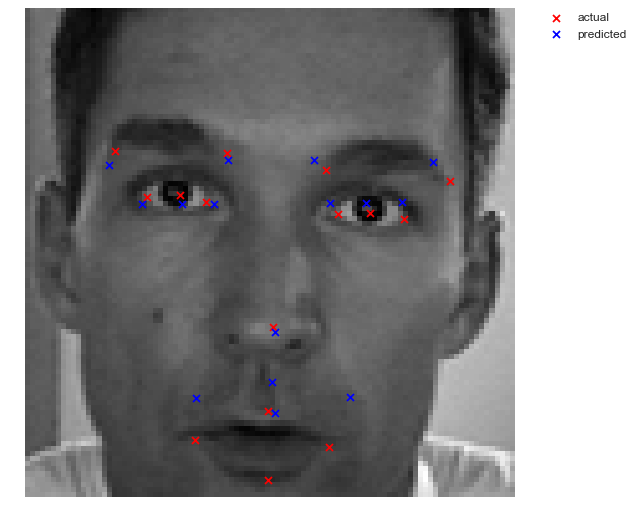

In [29]:
print ('RMSE of '+ str((self.score(self.dev_labels[example_num],
                                   label_scaler.inverse_transform(y_pred[example_num])))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], 
                  label_scaler.inverse_transform(y_pred[example_num]))

### Submissions

In [31]:
k_nn_submission = knn.predict(self.test_data)
self.submission_gen(k_nn_submission, 'knn')

In [32]:
mlp_submission = mlp.predict(data_scaler.transform(self.test_data))
self.submission_gen(label_scaler.inverse_transform(mlp_submission), 'mlp')

## Appendix

### Flipping Image Data

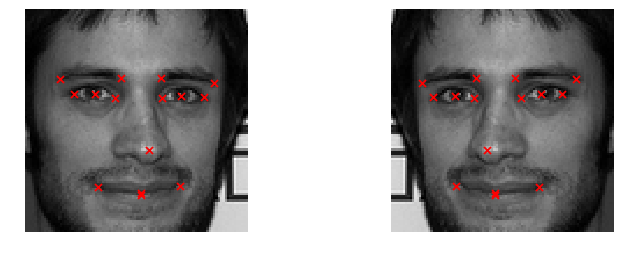

In [65]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data[0], self.train_labels[0], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.train_data_f[0], self.train_labels_f[0], legend=False)

## Grid Search to Find Best Parameters

In [ ]:
knn = KNeighborsRegressor()
parameters ={'n_neighbors': range(1, 25)}
clf = GridSearchCV(knn, parameters)
clf.fit(self.train_data, self.train_labels)
clf.best_params_

array([[ 0.01960784,  0.02352941,  0.02745098, ...,  0.63921569,
         0.64313725,  0.63921569],
       [ 0.21176471,  0.22745098,  0.24705882, ...,  0.77647059,
         0.76078431,  0.76078431],
       [ 0.4       ,  0.38039216,  0.34509804, ...,  0.5254902 ,
         0.53333333,  0.67843137],
       ..., 
       [ 0.21176471,  0.19215686,  0.17254902, ...,  0.67058824,
         0.66666667,  0.6627451 ],
       [ 1.        ,  1.        ,  0.99607843, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.97254902,  0.96470588,  0.96862745, ...,  0.42352941,
         0.40784314,  0.4       ]])